<a href="https://colab.research.google.com/github/matheusjagi/ml/blob/main/HousePrices_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Trabalho: House Prices - Advanced Regression Techniques

**Objetivo:** aplicar técnicas de aprendizado de máquina (scikit-learn) para prever o preço de venda de casas a partir do dataset *House Prices: Advanced Regression Techniques* (Kaggle).

**Observação:** coloque os arquivos `train.csv` e `test.csv` na pasta `./data/` antes de rodar o notebook.

### 1. Contextualização do Dataset

**Introdução:**
- Problema: prever o preço de venda (`SalePrice`) das casas com base em características físicas, de localização e estruturais.
- Tipo: regressão (variável alvo contínua).

In [1]:
# Imports principais
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# scikit-learn
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, learning_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import TransformedTargetRegressor

# modelos
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# para extrair nomes de features
import itertools

## 2. Carregar Dados

Link para download do dataset: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

In [3]:
DATA_DIR = Path("/content")
train_path = DATA_DIR / "train.csv"
test_path = DATA_DIR / "test.csv"

# verificar existência
if not train_path.exists():
  raise FileNotFoundError(f"Arquivo {train_path} não encontrado. Coloque train.csv em ./data/")

train = pd.read_csv(train_path)
print("train shape:", train.shape)
train.head()

train shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 3. Exploração Inicial
- Estatísticas básicas
- Verificar faltantes

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


Total features com valores faltantes: 19


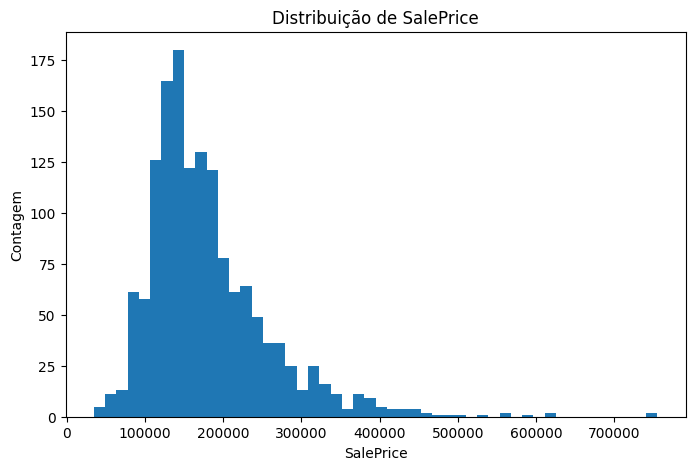

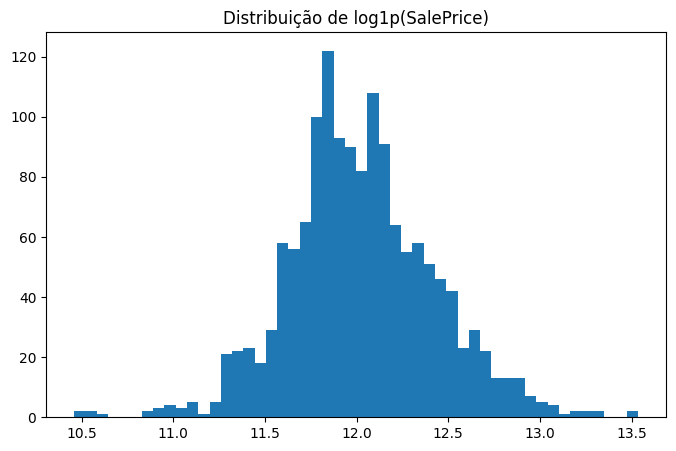

In [4]:
# estatísticas
display(train.describe().T)

# faltantes por feature
missing = train.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]
print("Total features com valores faltantes:", missing.shape[0])
missing.head(20)

# distribuição da variável alvo
plt.figure(figsize=(8,5))
plt.hist(train['SalePrice'], bins=50)
plt.title('Distribuição de SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Contagem')
plt.show()

# Observação: `SalePrice` costuma ser positivamente enviesado; é comum aplicar transformação log para regressão (estabiliza variância e melhora métricas como RMSE (Root Mean Squared Error).

# transformando alvo
train['SalePrice_log'] = np.log1p(train['SalePrice'])
plt.figure(figsize=(8,5))
plt.hist(train['SalePrice_log'], bins=50)
plt.title('Distribuição de log1p(SalePrice)')
plt.show()

## 4. Preparação dos Dados

In [5]:
# selecionar features iniciais
FEATURES = [
  'OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','YearBuilt',
  'YearRemodAdd','TotRmsAbvGrd','MasVnrArea','KitchenQual','Neighborhood','LotArea','LotConfig','BsmtExposure'
]

# filtrar as features existentes (por segurança)
FEATURES = [f for f in FEATURES if f in train.columns]
len(FEATURES), FEATURES

X = train[FEATURES].copy()
y = train['SalePrice'].copy()

# observar tipos
X.dtypes

# Identificar numéricas e categóricas
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

kitchen_order = ['Po', 'Fa', 'TA', 'Gd', 'Ex']  # ajustar se houver nomes diferentes
ordinal_cols = ['KitchenQual'] if 'KitchenQual' in X.columns else []
nominal_cols = [c for c in cat_cols if c not in ordinal_cols]

print('Numéricas:', num_cols)
print('Ordinais:', ordinal_cols)
print('Nominais:', nominal_cols)

# Pipeline de pré-processamento
# - Numéricas: imputar mediana e padronizar (StandardScaler)
# - Categóricas: imputar constante 'Missing' e one-hot encode (limitando número de categorias se necessário)

numeric_transformer = Pipeline(steps=[
  ('imputer', SimpleImputer(strategy='median')),
  ('scaler', StandardScaler())
])

ordinal_transformer = Pipeline(steps=[
  ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
  ('ord', OrdinalEncoder(categories=[kitchen_order], dtype=float))
])

categorical_transformer = Pipeline(steps=[
  ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
  ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
  ('num', numeric_transformer, num_cols),
  ('ord', ordinal_transformer, ordinal_cols),
  ('cat', categorical_transformer, nominal_cols)
])

Numéricas: ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'TotRmsAbvGrd', 'MasVnrArea', 'LotArea']
Ordinais: ['KitchenQual']
Nominais: ['Neighborhood', 'LotConfig', 'BsmtExposure']


## 5. Aplicação das técnicas de Aprendizado de Máquina

In [7]:
models = {
  'LinearRegression': LinearRegression(),
  'RandomForestRegressor': RandomForestRegressor(random_state=42),
  'KNeighborsRegressor': KNeighborsRegressor(n_neighbors=5)
}

from sklearn.preprocessing import FunctionTransformer
log_transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1, validate=True)

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Shapes: ", X_train.shape, X_test.shape)

# Pipeline geral
results = {}

for name, model in models.items():
    # pipeline: preprocessor -> estimator
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

    # wrap to transform target via log1p
    ttr = TransformedTargetRegressor(regressor=pipe, transformer=log_transformer)

    # treinar
    ttr.fit(X_train, y_train)
    preds = ttr.predict(X_test)  # já está no espaço original (exp() aplicado internamente).

    # metrics
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results[name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Converter o dicionário de resultados em DataFrame
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Modelo'})

# Ordenar pelo menor RMSE
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index':'Modelo'}).sort_values('RMSE')
results_df

Shapes:  (1168, 16) (292, 16)


,Modelo,RMSE,MAE,R2
0,LinearRegression,28367.202369,18354.133492,0.895089
1,RandomForestRegressor,28461.913775,17752.454120,0.894388
2,KNeighborsRegressor,36170.776821,20712.765760,0.829430


In [8]:
# ===========================
# Cross-Validation (KFold) com scoring e curva de aprendizado para o melhor modelo
# ===========================
from sklearn.model_selection import cross_val_score

best_name = results_df.iloc[0]['Modelo']
print("Melhor por RMSE (no teste):", best_name)

best_estimator = models[best_name]
pipe_best = Pipeline(steps=[('preprocessor', preprocessor), ('model', best_estimator)])
ttr_best = TransformedTargetRegressor(regressor=pipe_best, transformer=log_transformer)

# usar neg_mean_squared_error e converter para RMSE
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(ttr_best, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
rmse_scores = np.sqrt(-scores)
print("CV RMSE (5-fold): mean={:.4f}, std={:.4f}".format(rmse_scores.mean(), rmse_scores.std()))

Melhor por RMSE (no teste): LinearRegression
CV RMSE (5-fold): mean=46592.2561, std=40018.4001


## 6. Análise final - Resíduos e Erros

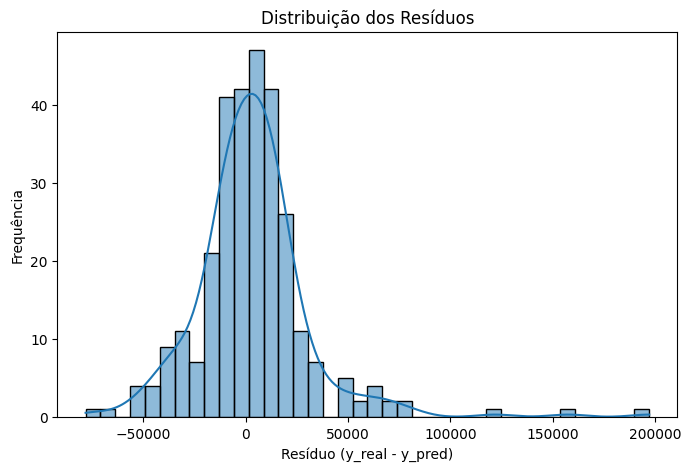

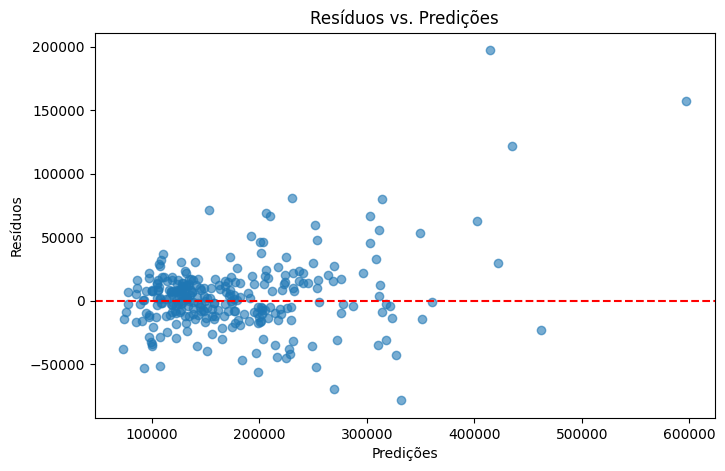

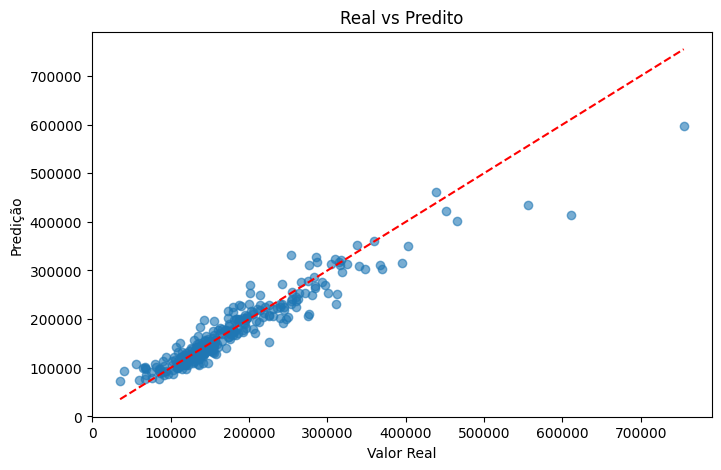

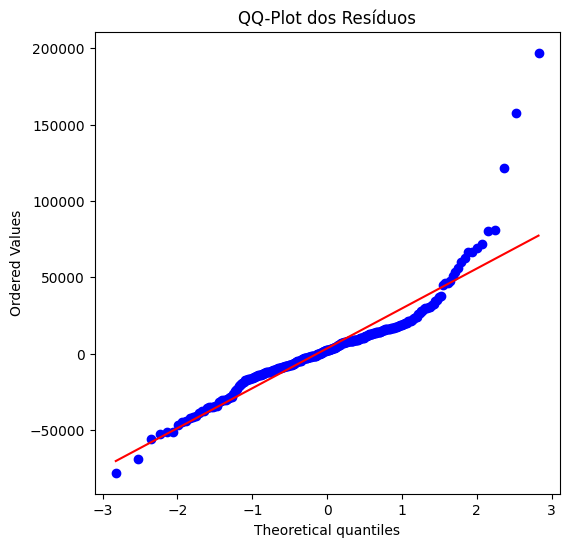

Total de outliers (|res| > 3σ): 3


,Real,Predito,Resíduo,Erro (%)
898,611657,414498.787473,197158.212527,32.233460
691,755000,597474.019946,157525.980054,20.864368
1046,556581,434757.837211,121823.162789,21.887769
218,311500,230677.166684,80822.833316,25.946335
774,395000,314606.059034,80393.940966,20.352896
581,253293,331441.786005,-78148.786005,-30.853117
607,225000,153453.178988,71546.821012,31.798587
529,200624,269948.008917,-69324.008917,-34.554195
426,275000,206092.369473,68907.630527,25.057320
208,277000,210302.166102,66697.833898,24.078640


In [12]:
import seaborn as sns
import scipy.stats as stats

# Treinar o melhor modelo novamente usando treino + teste (para análise completa)
ttr_best.fit(X_train, y_train)

y_pred = ttr_best.predict(X_test)
residuals = y_test - y_pred
error_pct = residuals / y_test * 100  # erro percentual

# ===============================
# 1. Histograma dos resíduos
# ===============================
plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True)
plt.title("Distribuição dos Resíduos")
plt.xlabel("Resíduo (y_real - y_pred)")
plt.ylabel("Frequência")
plt.show()

# ===============================
# 2. Resíduos vs. Predição
# ===============================
plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Resíduos vs. Predições")
plt.xlabel("Predições")
plt.ylabel("Resíduos")
plt.show()

# ===============================
# 3. Real vs Predito
# ===============================
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         color='red', linestyle='--')
plt.title("Real vs Predito")
plt.xlabel("Valor Real")
plt.ylabel("Predição")
plt.show()

# ===============================
# 4. QQ-Plot dos resíduos
# ===============================
plt.figure(figsize=(6,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ-Plot dos Resíduos")
plt.show()

# ===============================
# 5. Identificação de Outliers de Resíduos (> 3σ)
# ===============================
std_res = np.std(residuals)
mean_res = np.mean(residuals)
threshold = 3 * std_res

outliers = np.abs(residuals - mean_res) > threshold
outliers_idx = residuals[outliers].index

print("Total de outliers (|res| > 3σ):", len(outliers_idx))

# Mostrar os piores casos
df_errors = pd.DataFrame({
    "Real": y_test,
    "Predito": y_pred,
    "Resíduo": residuals,
    "Erro (%)": error_pct
})

df_bad = df_errors.reindex(outliers_idx).sort_values(by="Resíduo", key=abs, ascending=False)
df_bad.head(10)

# ===============================
# 6. Top 10 previsões com maiores erros absolutos
# ===============================
df_worst = df_errors.reindex(df_errors["Resíduo"].abs().sort_values(ascending=False).index)
df_worst.head(10)